# Problem 3: Hypothesis testing

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

## 1

We start with the veriﬁcation of the law of large numbers. Thus we check if an estimator converges (in probability) to its true value if the sample size increases.

### 1.a

Simulate samples of size $n = 100, \dots , 100000$ from a normal distribution with mean 1 and variance 1, i.e. $N(1, 1)$. For each sample estimate the mean, the variance and store them.

In [138]:
np.random.seed(0)

lognmax = 5
n_min = 10**2
n_max = 10**lognmax
ns = np.arange(n_min, n_max, 200)
num_experiments = len(ns)
print('{} samples in total. Some of them:'.format(num_experiments))
mu1 = 1
sigma1 = 1
var1 = sigma1**2
rv_norm1 = stats.norm(loc=mu1, scale=sigma1)
sample_means = []
sample_vars = []
priniter = 20
for i, n in enumerate(ns):
    sample = rv_norm1.rvs(size=n)
    sample_mean = sample.mean()
    sample_var = sample.var(ddof=1)
    sample_means.append(sample_mean)
    sample_vars.append(sample_var)
    if i % priniter == 0:
        print('N({},{}) | Generated sample of size {:<{}}'\
              .format(mu1, sigma1**2, n, lognmax+1) + \
      ' | Est. Mean: {:6.3f} | Est. Variance: {:6.3f}'.format(sample_mean,
                                                              sample_var))

500 samples in total. Some of them:
N(1,1) | Generated sample of size 100    | Est. Mean:  1.060 | Est. Variance:  1.026
N(1,1) | Generated sample of size 4100   | Est. Mean:  1.004 | Est. Variance:  0.964
N(1,1) | Generated sample of size 8100   | Est. Mean:  1.011 | Est. Variance:  0.997
N(1,1) | Generated sample of size 12100  | Est. Mean:  1.011 | Est. Variance:  0.984
N(1,1) | Generated sample of size 16100  | Est. Mean:  0.997 | Est. Variance:  1.009
N(1,1) | Generated sample of size 20100  | Est. Mean:  0.992 | Est. Variance:  0.997
N(1,1) | Generated sample of size 24100  | Est. Mean:  1.000 | Est. Variance:  0.989
N(1,1) | Generated sample of size 28100  | Est. Mean:  1.001 | Est. Variance:  1.002
N(1,1) | Generated sample of size 32100  | Est. Mean:  0.997 | Est. Variance:  0.999
N(1,1) | Generated sample of size 36100  | Est. Mean:  0.997 | Est. Variance:  0.995
N(1,1) | Generated sample of size 40100  | Est. Mean:  1.003 | Est. Variance:  1.004
N(1,1) | Generated sample of 

Plot the path of sample means and sample variances as function of n.

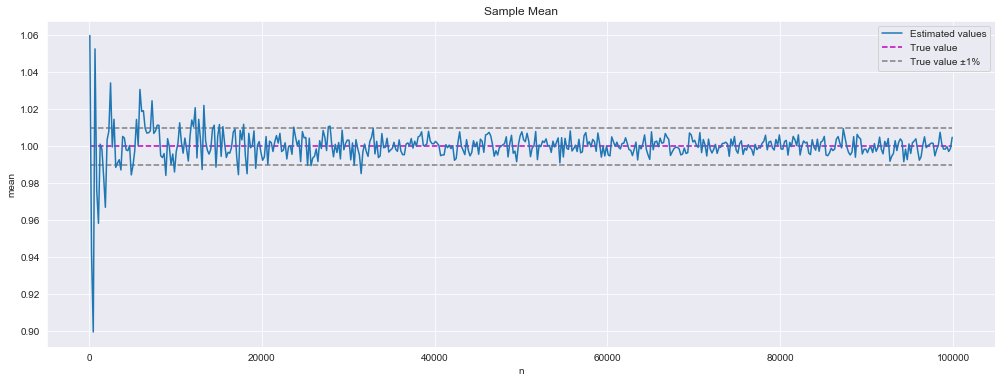

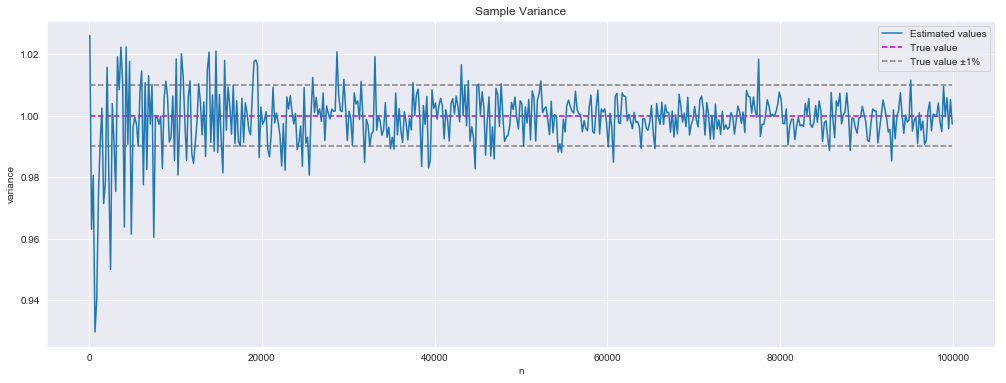

In [167]:
delta = 0.01
mpl.rcParams['figure.figsize'] = (17,6)

def plot_parameter(ns, estimated_values, true_value,
                   delta=None,
                   cs=None, alpha=None,
                   parameter_name=''):
    '''
    delta -- constant small deviation from the true_value;
             the horizontal lines with values of
             `(1 + delta) * true_value` will be plotted
    cs -- deviations to construct the confidence intervals 
    '''
    plt.title('Sample {}'.format(parameter_name))
    plt.xlabel('n')
    plt.ylabel(parameter_name.lower())
    plt.plot(ns, estimated_values, label='Estimated values')
    plt.hlines(true_value, ns[0], ns[-1], 'm', '--', label='True value')
    if delta is not None:
        plt.hlines((1+delta)*true_value, ns[0], ns[-1], 'gray', '--',
                   label='True value ±{}%'.format(int(delta*100)))
        plt.hlines((1-delta)*true_value, ns[0], ns[-1], 'gray', '--')
    if cs is not None:
        if isinstance(cs, tuple):
            cs_lw, cs_up = cs[0], cs[1]
        else:
            cs_lw, cs_up = estimated_values - cs, estimated_values + cs
        plt.plot(ns, cs_up, '--', color='gray',
                label='{}% confidence interval for the {}'\
                 .format(int((1-alpha)*100), parameter_name.lower()))
        plt.plot(ns, cs_lw, '--', color='gray')
    plt.legend()
    plt.show()

plot_parameter(ns, sample_means, mu1, delta=delta, parameter_name='Mean')
plot_parameter(ns, sample_vars, var1, delta=delta, parameter_name='Variance')

> The plots support the LLN. As $n$ becomes bigger the estimated values become closer to the true values.

How many observations do we need in order to obtain an estimator which is close enough (±1%) to the true value?

In [173]:
def min_num_observations(ns, estimated_values, true_value, delta):
    index = [(np.array(estimated_values)[i:] > (1-delta)*true_value).all() and
             (np.array(estimated_values)[i:] < (1+delta)*true_value).all()
                               for i in range(len(ns))].index(True)
    return ns[index]

min_observations_mean = min_num_observations(ns, sample_means, mu1, delta)
min_observations_var = min_num_observations(ns, sample_vars, var1, delta)
min_observations = max(min_observations_mean, min_observations_var)
print('Experimentally we get that:')
print('\tAfter {:5} observations mean estimator is close enough (±1%) to the true mean'.format(min_observations_mean))
print('\tAfter {:5} observations variance estimator is close enough (±1%) to the true variance'.format(min_observations_var))
print('\t=> After {:5} observations estimations are close enough to the true mean and variance'.format(min_observations))

Experimentally we get that:
	After 31700 observations mean estimator is close enough (±1%) to the true mean
	After 95300 observations variance estimator is close enough (±1%) to the true variance
	=> After 95300 observations estimations are close enough to the true mean and variance


> To get the number of observations theoretically we should use the known true value of $\sigma$ and set the confidence level to $1 - \alpha$ e.g. 0.95:
>
>\begin{equation}
P\left(|\mu - \overline X| < z_{1 - \alpha/2} \frac{\sigma}{\sqrt{n}}\right) > 1 - \alpha
\end{equation}
>
> We want $|\mu - \overline X| < 0.01\mu = 0.01$
>\begin{equation}
\Rightarrow z_{1 - \alpha/2} \frac{\sigma}{\sqrt{n}} = 0.01
\end{equation}
>
>\begin{equation}
n = z^2_{1 - \alpha/2} \frac{\sigma^2}{0.0001}
\end{equation}

In [180]:
alpha = 0.05
n = stats.norm.ppf(1 - alpha/2) ** 2 * var1 / (0.01*mu1)**2
print('We need more than {:.0f} observations to obtain an estimator close enough (±1%) to the true value'.format(n))

We need more than 38415 observations to obtain an estimator close enough (±1%) to the true value


#### 1.b

Add to the plot the 95% conﬁdence intervals. These have to be constructed manually. Provide their interpretation.

> For the mean the confidence interval is provided with unknown $\sigma$ (more often we don't now the true variance):
>
> \begin{equation}
\left ( \overline{X} - t_{n-1; 1 - \alpha/2} \frac{S}{\sqrt{n}}; \overline{X} + t_{n-1; 1 - \alpha/2} \frac{S}{\sqrt{n}} \right)
\end{equation}
>
> Analogously the confidence interval for the variance is constructed as we don't know the true mean:
>
> \begin{equation}
\left ( \frac{(n-1) S^2}{ \chi^2_{n-1; 1 - \alpha/2} }; \frac{(n-1) S^2}{ \chi^2_{n-1; \alpha/2} } \right)
\end{equation}

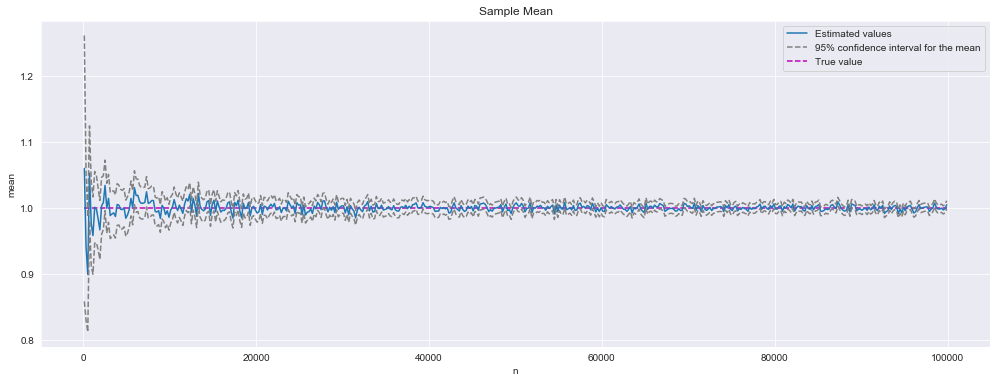

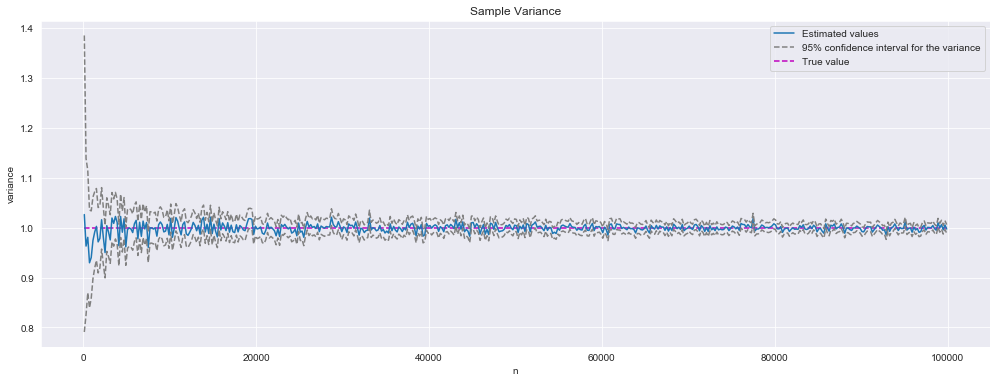

In [172]:
alpha = 0.05

cs = np.array([stats.t.ppf(1-alpha/2, df=n-1) * np.sqrt(S2/n) 
               for (n,S2) in zip(ns, sample_vars)])
plot_parameter(ns, sample_means, mu1, cs=cs, alpha=alpha,
               parameter_name='Mean')

cs_lw = np.array([S2*(n-1) / stats.chi2.ppf(1-alpha/2, df=n-1) 
                  for (n,S2) in zip(ns, sample_vars)])
cs_up = np.array([S2*(n-1) / stats.chi2.ppf(alpha/2, df=n-1) 
                  for (n,S2) in zip(ns, sample_vars)])
plot_parameter(ns, sample_vars, var1, cs=(cs_lw, cs_up), 
               alpha=alpha, parameter_name='Variance')

> With 95% confidence we are sure that the true parameter value is inside the confidence interval.

## 2

The 2nd objective of this part is to get more feeling for the ML estimation procedures. The estimation for non-standard distributions/models usually follows the maximum likelihood principle. The t-distribution is a popular alternative if the sample distribution is symmetric but exhibits heavier tails compared to the normal distribution.

#### 2 (a)

Let $x_1 , \dots, x_n$ be a given sample. We assume that it stems from a t-distribution with an unknown number of degrees of freedom. Write down the corresponding likelihood function.

>\begin{equation}
X_1, \dots, X_n \sim t_d:
\qquad
f(x_i) = \frac{(1 + \frac{x_i^2}{d})^{-\frac{d+1}2}}{B(d/2, 1/2) \sqrt d}
\end{equation}
>
>\begin{equation}
L_d(x_1, \dots, x_n) =
\prod_{i=1}^n \frac{(1 + \frac{x_i^2}{d})^{-\frac{d+1}2}}{B(d/2, 1/2) \sqrt d} =
\frac{\prod_{i=1}^n (1 + \frac{x_i^2}{d})^{-\frac{d+1}2}}{B^n(d/2, 1/2) \cdot d^{n/2}}
\end{equation}
>
>\begin{equation}
\ln L_d(x_1, \dots, x_n) =
\frac{-\frac{d+1}2 \sum_{i=1}^n \ln(1 + \frac{x_i^2}{d})}{n \ln(B(d/2, 1/2) \cdot \sqrt d)}
\end{equation}

#### 2 (b)

Simulate a sample of size n = 100 from $t_5$ . Maximize the likelihood function (numerically) for the given sample and obtain the ML estimator of the number of degrees of freedom.

In [18]:
def log_likelihood(pdfs):
    return np.sum(np.log(pdfs))

df* = 4.59 maximizes likelihood function


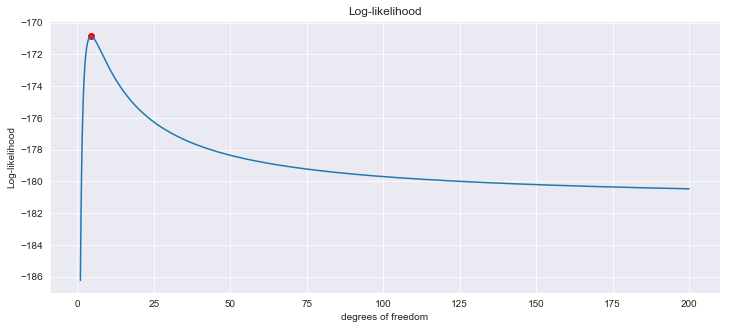

In [185]:
mpl.rcParams['figure.figsize'] = (12, 5)
np.random.seed(100)

d_true = 5
n = 100
rv_st = stats.t(df=d_true)
sample_st = rv_st.rvs(size=n)

ds = np.linspace(1,200,1000)
Ls = []
for d in ds:
    pdfs = stats.t(df=d).pdf(sample_st)
#     plt.scatter(sample_st, pdfs)
    Ls.append(log_likelihood(pdfs))
# plt.show()
d_est = ds[np.argmax(Ls)]
print('df* = {:.2f} maximizes likelihood function'.format(d_est))

plt.title('Log-likelihood')
plt.xlabel('degrees of freedom')
plt.ylabel('Log-likelihood')
plt.plot(ds, Ls)
plt.scatter(d_est, np.max(Ls), color='red')
plt.show()

#### 2 (c)

The classical theoretical t-distribution has zero mean and variance df/(df −2). A real sample does not have exactly these moments. How would you proceed if you need to ﬁt a t-distribution to real data?

> If we transform random variable $X$ s.t. $Y = \sigma X + \mu$ then $F_Y(x) = F_X(\frac{x - \mu}{\sigma})$ and $f_Y(x) = F'_X(\frac{x - \mu}{\sigma}) = \frac1{\sigma}f_X(\frac{x - \mu}{\sigma})$
>
> We can use it with transformed Student r.v. to calculate likekihood:
>
> \begin{equation}
L(x_1, \dots, x_n) = \prod_{i=1}^n \frac1{\sigma}f_X\left(\frac{x - \mu}{\sigma}\right)
\end{equation}
>
> As was shown in previous assignment we can transform r. v. X from Student distribution with $n$ degrees of freedom s.t. it has mean $\mu$ and variance $\sigma^2$: $Y = \sigma \sqrt{\frac{n-2}{n}} X  + \mu$.
> So we can estimate $n$ using ML and thus fit $t_n$-distribution to our data.

df* = 4.78 maximizes likelihood function


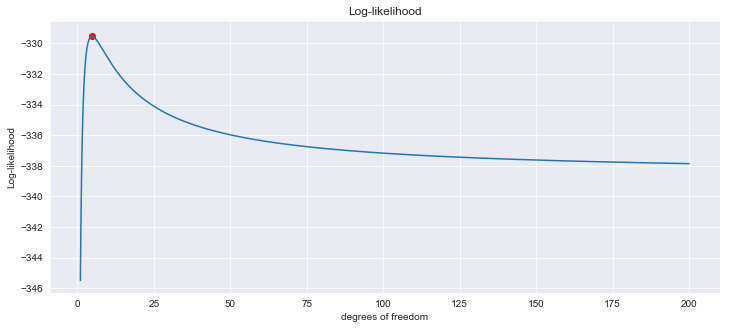

In [197]:
mpl.rcParams['figure.figsize'] = (12, 5)
np.random.seed(100)

d_true = 5
n = 100

mu = 10
sigma = 5
sample_st = mu + sigma * np.sqrt((df-2) / df) * stats.t(df=d_true).rvs(size=n)

ds = np.linspace(1,200,1000)
Ls = []
for d in ds:
    pdfs = stats.t(df=d).pdf((sample_st - mu) / sigma) / sigma
    Ls.append(log_likelihood(pdfs))
d_est = ds[np.argmax(Ls)]
print('df* = {:.2f} maximizes likelihood function'.format(d_est))

plt.title('Log-likelihood')
plt.xlabel('degrees of freedom')
plt.ylabel('Log-likelihood')
plt.plot(ds, Ls)
plt.scatter(d_est, np.max(Ls), color='red')
plt.show()

## 3

The 3rd objective is check if the probability of type 1 error (size of a test) is correctly attained by a simple two-sided test for the mean.

#### 3 (a)

Simulate a sample of length $n = 100$ from a normal distribution with mean $\mu_0 = 500$ and variance $\sigma_2 = 50$. (Note: you may use the transformation $X = \mu + \sigma Z$, where $Z \sim N(0, 1)$.) The objective is to test the null hypothesis $H_0 : \mu = 500$. Assume that $\sigma_2$ has to be estimated. Compute the test statistics using the formulas in the lecture; determine the rejection area for $\alpha = 0.04$ and decide if $H_0$ can to be rejected.

In [23]:
np.random.seed(0)

n = 100
mu = 500
sigma = 50

rv = stats.norm(loc=mu, scale=sigma)
x = rv.rvs(size=n)

In [24]:
def normal_cdf(x):
    return stats.norm().cdf(x)

def normal_ppf(F):
    return stats.norm().ppf(F)

def student_cdf(df, x):
    return stats.t(df=df).cdf(x)

def student_ppf(df, F):
    return stats.t(df=df).ppf(F)

def two_sided_Z_test(x, a, alpha=None, sigma=None, out=True):
    '''
    H0: mu == a
    H1: mu != a
    alpha -- significance level
    '''
    if out:
        print('\nTwo-sided Z-test {}'.format('(sigma is unknown)' 
                                             if sigma is None else ''))
        print('H0: mu == {}'.format(a))
        print('H1: mu != {}'.format(a))
    n = len(x)
    sample_mean = np.mean(x)
#     print('\tSample mean: {:.2f}'.format(sample_mean))
    if sigma is None:
        sample_var = np.var(x, ddof=1)
#         print('\tSample variance: {:.2f}'.format(sample_var))
        v = (sample_mean - a) * sqrt(n) / sqrt(sample_var)
        p_value = 2 * student_cdf(n-1, v) if v < 0 else \
                  2 * (1 - student_cdf(n-1, v))
        if alpha is not None:
            t_crit = student_ppf(n-1, 1-alpha/2)
    else:
        v = (sample_mean - a) * sqrt(n) / sigma
        p_value = 2 * normal_cdf(v) if v < 0 else 2 * (1 - normal_cdf(v))
        if alpha is not None:
            t_crit = normal_ppf(1-alpha/2)
            
    if alpha is not None:
        rejected = v < -t_crit or v > t_crit
        if out:
            print('The rejection area is: (-inf, -{:.3f}) ∪ ({:.3f}, inf)'\
                  .format(t_crit, t_crit))
            print('t_stat = {:.3f} is {} in the rejection area.'\
                  .format(v, '' if rejected else 'not'))
            if not rejected:
                print('With significance level of {}% we cannot reject H0.'\
                      .format(alpha*100, a))
            else:
                print('With significance level of {}% we can reject H0.')
        return p_value, rejected
    if out:
        print('p-value is {:.3f}'.format(p_value))
        print('For all α > {:.3f} we can reject H0.'.format(p_value))
    return p_value

_, _ = two_sided_Z_test(x, mu, 0.04)


Two-sided Z-test (sigma is unknown)
H0: mu == 500
H1: mu != 500
The rejection area is: (-inf, -2.081) ∪ (2.081, inf)
t_stat = 0.590 is not in the rejection area.
With significance level of 4.0% we cannot reject H0.


#### 3 (b)

Determine the p-values using the formulas from the lecture and compare/check the results using a build-in function for this test in R or Python.

In [31]:
p_value = two_sided_Z_test(x, mu)

tstat, pvalue = stats.ttest_1samp(x, mu)
print('\np-value from `scipy.stats` is {:.3f}'.format(pvalue))


Two-sided Z-test (sigma is unknown)
H0: mu == 500
H1: mu != 500
p-value is 0.556
For all α > 0.556 we can reject H0.

p-value from `scipy.stats` is 0.556


> So implemented p-value is the same as within `scipy.stats`.

#### 3 (c)

Simulate $M = 1000$ samples of size $n = 100$ and with $µ_0 = 500$ and variance $\sigma^2 = 50$. For each sample $i$ run the test (using a standard function) and set $p_i = 0$ if $H_0$ is not rejected and $p_i = 1$ if rejected. Compute $\hat \alpha = \frac1M\sum_{i=1}^M p_i$ . $\hat \alpha$ is the empirical conﬁdence level (empirical size) of the test. Compare $\hat \alpha$ to $\alpha$? Do you expect the diﬀerence to be large or small and why? Relate it to the assumptions of the test.

In [111]:
M = 1000
n = 100
mu = 500
sigma = np.sqrt(50)
alpha = 0.04

rv = stats.norm(loc=mu, scale=sigma)
X = rv.rvs(size=n*M).reshape((M,n))
P = []
for x in X:
    _, pvalue = sm.stats.ztest(x, value=mu)
    rejected = alpha > pvalue
    P.append(int(rejected))

In [112]:
print('Empirical conﬁdence level: {}, level of significance  {}'\
      .format(np.mean(P), alpha))

Empirical conﬁdence level: 0.044, level of significance  0.04


> The expectations are that the empirical confidence level would be close to $\alpha$. Since we assume that data is normally distributed we should get the type 1 error with probability $\alpha$. So for our $1000$ experiments we should get roughly $1000\alpha = 40$ rejections, indeed we got 44. The bigger is $M$ the closer $\hat\alpha$ should be to $\alpha$, due to the Law of Large Numbers.

#### 3 (d)

Assume now that one of the assumptions is not satisﬁed. For example, the data is in fact not normal. Repeat the above analysis, but simulate the data from the t-distribution with 3 degrees of freedom. Give motivation and justiﬁcation for the new values of $\hat\alpha$ ?

In [123]:
M = 1000
n = 100
df = 3

rv = stats.t(df=df)
X = rv.rvs(size=n*M).reshape((M,n))
X = mu + sigma * np.sqrt((df-2) / df) * X 
P = []
for x in X:
    _, pvalue = sm.stats.ztest(x, value=mu)
    rejected = alpha > pvalue
    P.append(int(rejected))

In [124]:
print('Empirical conﬁdence level: {}'.format(np.mean(P), alpha))

Empirical conﬁdence level: 0.033


> We should also get empirical value relatively close to the level of significance since the distribution of the data is close to normal. Nevertheless the assumptions on the normal distribution are not fullfiled so we may need a bigger number of experiments to get a very close estimate.

#### 3 (e)

**Power of a test**: The ﬁrst objective is to assess the probability of type 2 error (power of a test) of goodness-of-ﬁt test. Goodness-of-ﬁt tests for the normal distribution are of key importance in statistics, since they allow to verify the distributional assumptions required in many models. Here we check the power of the Kolmogorov-Smirnov test, i.e. is the test capable to detect deviations from normality?
    

Simulate $M = 1000$ samples of size 100 from a t-distribution with $df = 2, \dots, 50$ degrees of freedom. For each sample run the Kolmogorov-Smirnov test and count the cases when the $H_0$ of normality is correctly rejected (for each df). How would you use this quantity to estimate the power of the test? Make an appropriate plot with the df on the X-axis. (Note: the t-distribution converges to the normal distribution as df tends to inﬁnity. For $df > 50$ the distributions are almost identical. Discuss the plot and draw conclusions about the reliability of the test.

In [131]:
np.random.seed(0)

M = 1000
n = 100
dfs = np.arange(2,50)
print('H0: X ~ Normal')
print('H1: X !~ Normal')
alphas = []
for df in dfs:
    rv = stats.t(df=df)
    X = rv.rvs(size=n*M).reshape((M,n))
    P = []
    for x in X:
        ksstat, pvalue = stats.kstest(x, 'norm')
        rejected = ksstat > pvalue
        P.append(int(rejected))
    alphas.append(np.mean(P))

H0: X ~ Normal
H1: X !~ Normal


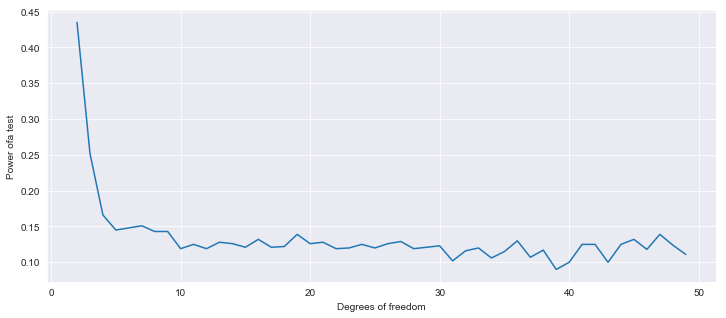

In [135]:
plt.plot(dfs, alphas)
plt.ylabel('Power ofa test')
plt.xlabel('Degrees of freedom')
plt.show()

> The data is not distributed normally so $H_0$ of the Kolmogorov-Smirnov test should be rejected. A test's power ($1 - \beta$) is the probability that the test rejects the $H_0$ when $H_1$ is true. So the frequency of rejection $H_0$ with our data can be used as a direct estimation of a test's power.
> From the plot we see that as df grows the $H_0$ is rejected less frequently, meaning that the test's power decreases. This is expectable since the t-distribution becomes closer to the normal distribution with increasing df.